# Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report, 
    roc_curve, 
    roc_auc_score,
    ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.decomposition import PCA



# Load Dataset

In [2]:
# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')

# EDA (Exploratory Data Analysis)

In [4]:
# Cek struktur data
print(data.head())
print("\nInfo dataset:")
print(data.info())
print("\nStatistik deskriptif:")
print(data.describe())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

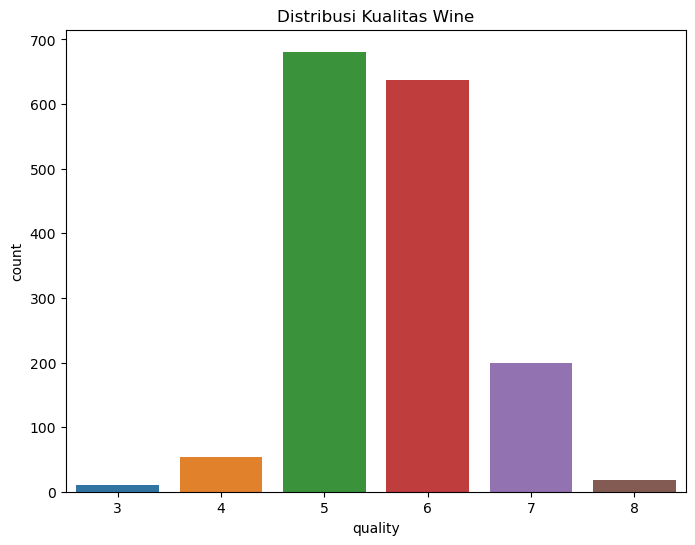

In [5]:
# Distribusi kelas target
plt.figure(figsize=(8, 6))
sns.countplot(x='quality', data=data)
plt.title("Distribusi Kualitas Wine")
plt.show()

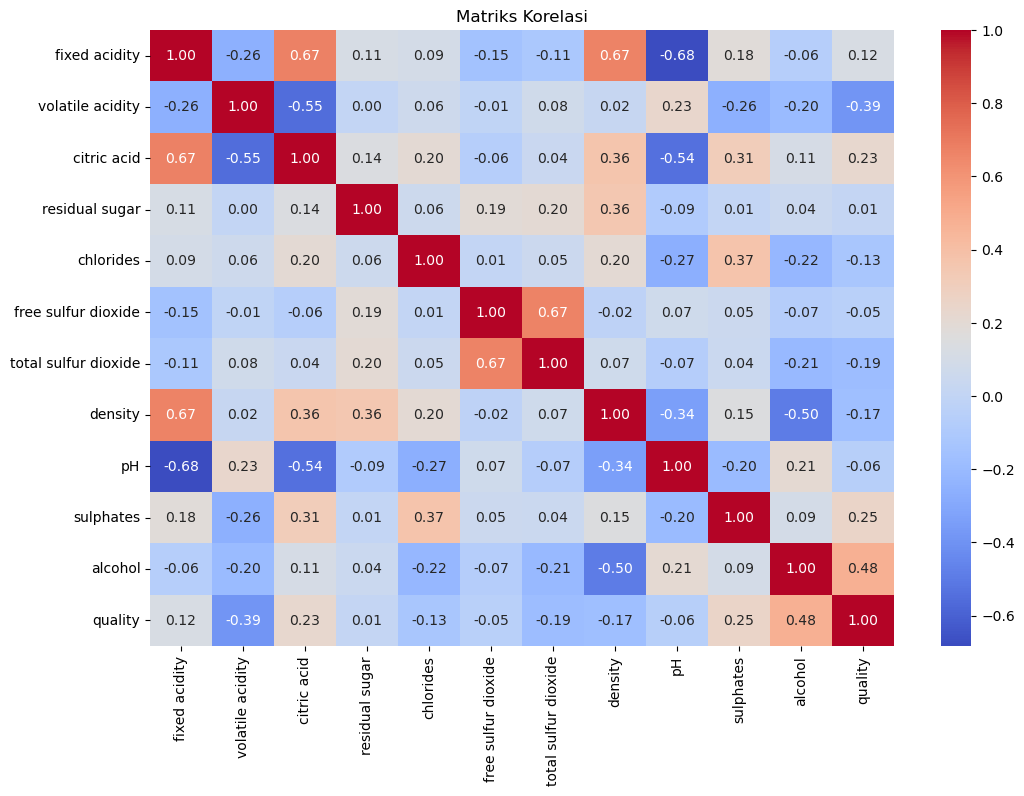

In [6]:
# Korelasi antar fitur
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriks Korelasi")
plt.show()



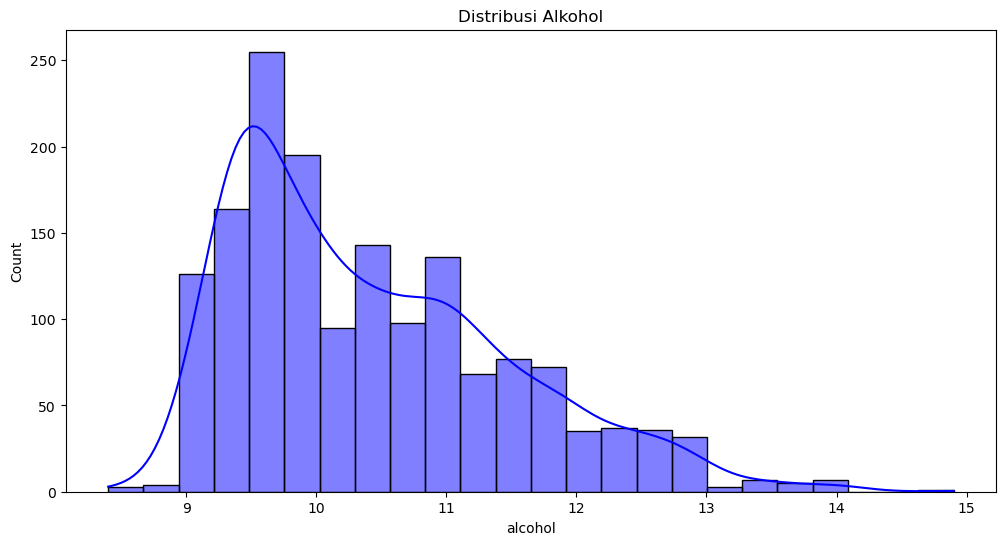

In [7]:
# Distribusi fitur penting
plt.figure(figsize=(12, 6))
sns.histplot(data['alcohol'], kde=True, color='blue')
plt.title("Distribusi Alkohol")
plt.show()

# Preprocessing Data

In [8]:
# Bagi data menjadi fitur dan target
X = data.drop('quality', axis=1)
y = data['quality']

# Binerisasi target (contoh: kualitas >=7 = "baik", <7 = "buruk")
y = np.where(y >= 7, 1, 0)  # 1 = baik, 0 = buruk

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Scaling fitur
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training Model Hyperparameter Tuning

In [9]:
# Definisi model dan hyperparameter
models = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {"C": [0.1, 1, 10], "solver": ["liblinear", "saga"]}
    },
    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {"n_estimators": [100, 200], "max_depth": [10, 20]}
    },
    "SVM": {
        "model": SVC(probability=True),
        "params": {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]}
    },
    "XGBoost": {
        "model": XGBClassifier(),
        "params": {"n_estimators": [100, 200], "learning_rate": [0.01, 0.1]}
    }
}



In [15]:
# Pelatihan dan evaluasi model
results = {}
for name, config in models.items():
    clf = GridSearchCV(config["model"], config["params"], cv=5, scoring='accuracy')
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    y_proba = clf.predict_proba(X_test_scaled)[:, 1]  # Untuk ROC-AUC
    
   # Di dalam loop pelatihan model:
    results[name] = {
        "best_params": clf.best_params_,
        "accuracy": accuracy_score(y_test, y_pred),
        "y_proba": y_proba,  # Simpan probabilitas untuk ROC
        "roc_auc": roc_auc_score(y_test, y_proba),  # Hitung AUC di sini
        "confusion_matrix": confusion_matrix(y_test, y_pred),
        "classification_report": classification_report(y_test, y_pred, output_dict=True)
    }

# Visualisasi Hasil

## 1. Perbandingan Akurasi dan ROC-AUC

<Figure size 1200x600 with 0 Axes>

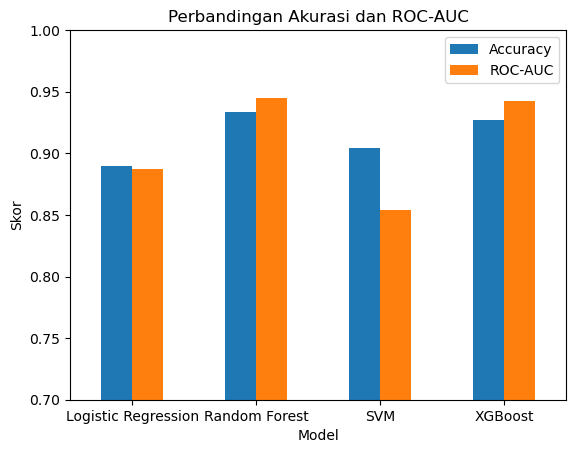

In [16]:
# Dataframe hasil
df_results = pd.DataFrame({
    "Model": results.keys(),
    "Accuracy": [results[name]["accuracy"] for name in results],
    "ROC-AUC": [results[name]["roc_auc"] for name in results]
})

# Plot
plt.figure(figsize=(12, 6))
df_results.set_index("Model").plot(kind='bar', rot=0)
plt.title("Perbandingan Akurasi dan ROC-AUC")
plt.ylabel("Skor")
plt.ylim(0.7, 1.0)
plt.show()

## 2. Kurva ROC

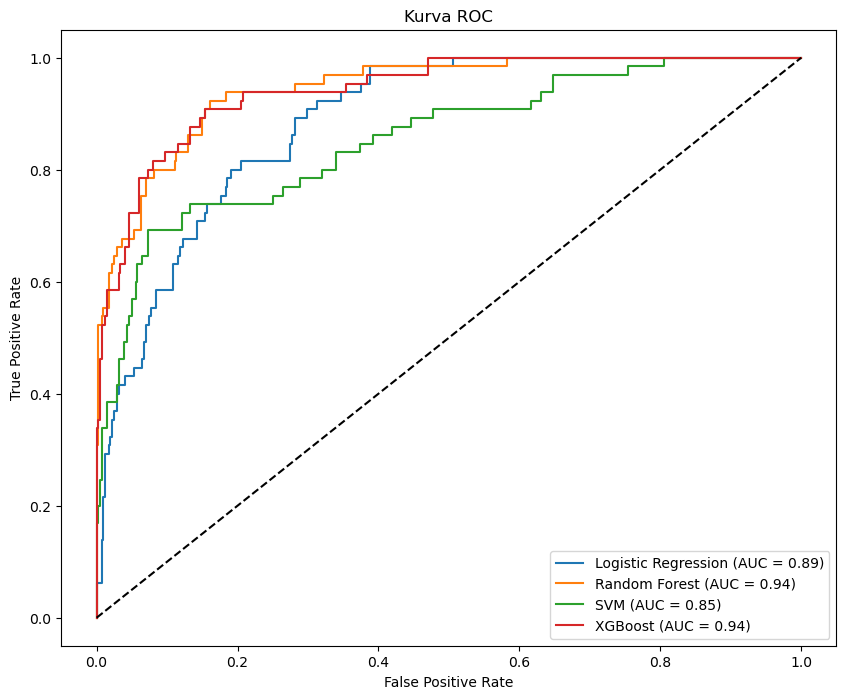

In [17]:
plt.figure(figsize=(10, 8))
for name in results:
    y_proba = results[name]["y_proba"]  # Ambil probabilitas yang disimpan
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)  # Hitung AUC dari probabilitas
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Kurva ROC")
plt.legend()
plt.show()

## 3. Confusion Matrix

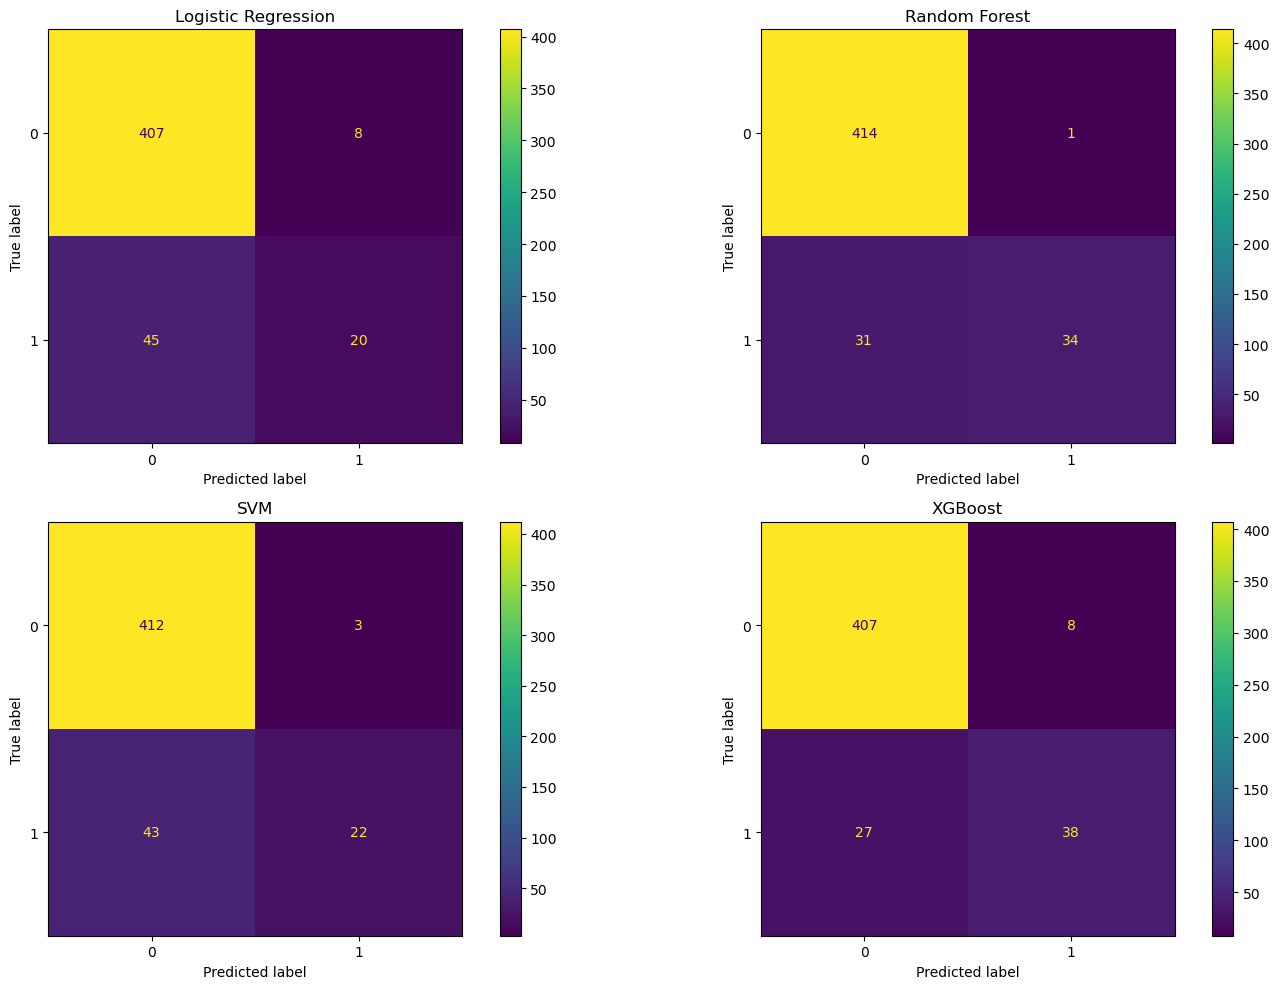

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for ax, (name, result) in zip(axes.flatten(), results.items()):
    ConfusionMatrixDisplay(result["confusion_matrix"]).plot(ax=ax)
    ax.set_title(name)
plt.tight_layout()
plt.show()

## Features Importance

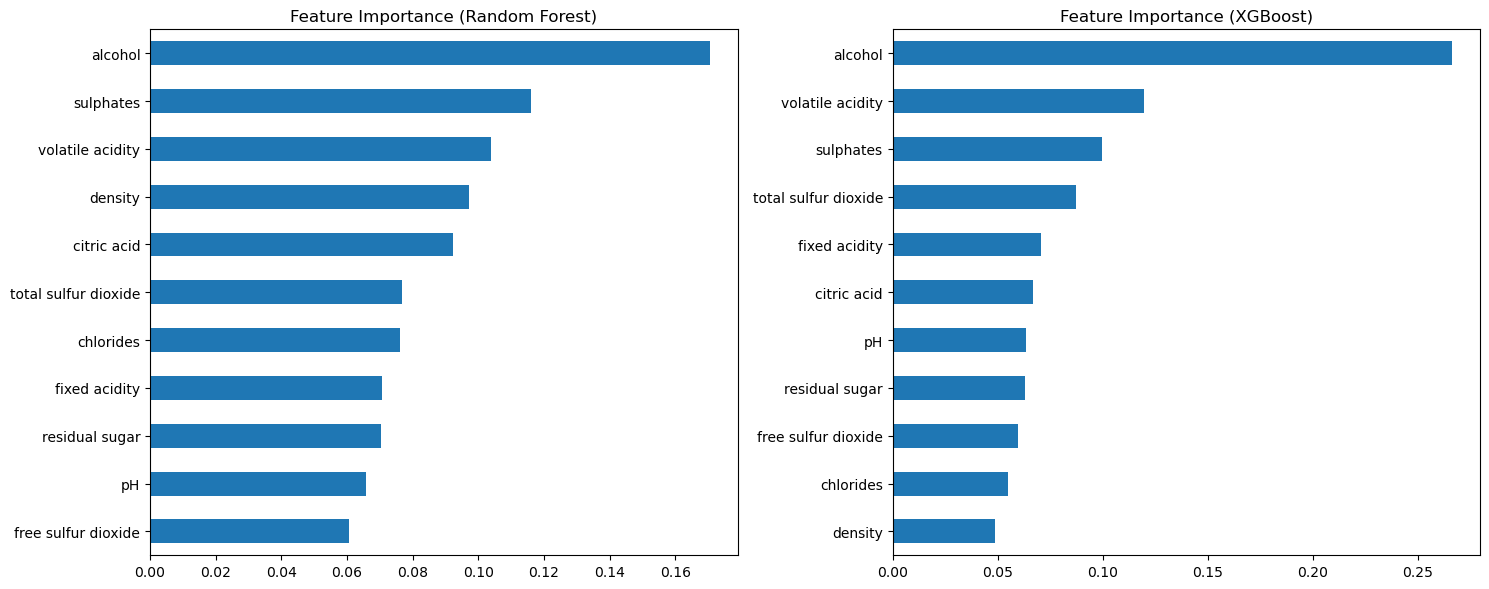

In [19]:
# Contoh untuk Random Forest dan XGBoost
rf_model = RandomForestClassifier(**results["Random Forest"]["best_params"])
rf_model.fit(X_train_scaled, y_train)

xgb_model = XGBClassifier(**results["XGBoost"]["best_params"])
xgb_model.fit(X_train_scaled, y_train)

# Plot feature importance
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
pd.Series(rf_model.feature_importances_, index=X.columns).sort_values().plot(kind='barh', ax=axes[0])
axes[0].set_title("Feature Importance (Random Forest)")

pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values().plot(kind='barh', ax=axes[1])
axes[1].set_title("Feature Importance (XGBoost)")
plt.tight_layout()
plt.show()